# Decision Tree 결정 나무, 의사 결정 나무

- 분류와 회귀 모두에 사용되는 지도학습 알고리즘이다.
- 분석 과정이 직관적이고 이해와 설명하기가 쉽다.
- 스케일링 등의 전처리 영향도가 크지 않다.



# 0. 라이브러리 불러오기 및 데이터 준비하기

In [27]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

In [28]:
# 데이터 읽어오기
path = './data/titanic.csv'
data = pd.read_csv(path)

# 1. 데이터 파악하기

In [29]:
# 상위 몇 개 행 확인
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [30]:
# 기술통계 확인
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [31]:
# Survived 확인
data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [32]:
# NaN 값 확인
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [33]:
# 상관관계 확인
data.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


# 2. 데이터 전처리

**1) 변수 제거**

- 분석에 의미가 없다고 판단되는 변수는 제거한다.

In [34]:
# 제거 대상: PassengerId, Name, Ticket, Cabin
drop_cols = ['PassengerId', 'Name', 'Ticket', 'Cabin']

# 변수 제거
data.drop(drop_cols, axis=1, inplace=True)

# 확인
data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


**2) 결측치 처리**

- 결측치가 있으면 제거하거나 적절한 값으로 채운다.

In [35]:
# Age 결측치를 중앙값으로 채우기
age_median = data['Age'].median()
data['Age'].fillna(age_median, inplace=True)

In [36]:
# Embarked 최빈값으로 채우기
emb_freq = data['Embarked'].mode()[0]
data['Embarked'].fillna(emb_freq, inplace=True)

**3) x, y 분리**

- target 변수를 명확히 지정한다.
- target을 제외한 변수를 x 데이터프레임으로 선언한다.
- y 데이터프레임은 target 변수만을 가진다.

In [37]:
# target 확인
target = 'Survived'

# 데이터 분리
x = data.drop(target, axis=1)
y = data.loc[:, target]

x.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,22.0,1,0,7.2500,S
1,1,female,38.0,1,0,71.2833,C
2,3,female,26.0,0,0,7.9250,S
3,1,female,35.0,1,0,53.1000,S
4,3,male,35.0,0,0,8.0500,S


**4) 가변수화**

- 범주형 변수에 대한 가변수화를 진행한다.

In [38]:
# 가변수화 대상: Pclass, Sex, Embarked
dumm_cols = ['Pclass', 'Sex', 'Embarked']

# 가변수화
x = pd.get_dummies(x, columns=dumm_cols, drop_first=True)

# 확인
x.head()

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S
0,22.0,1,0,7.2500,0,1,1,0,1
1,38.0,1,0,71.2833,0,0,0,0,0
2,26.0,0,0,7.9250,0,1,0,0,1
3,35.0,1,0,53.1000,0,0,0,0,1
4,35.0,0,0,8.0500,0,1,1,0,1


**5) 학습용, 평가용 데이터 분리**

- 학습용, 평가용 데이터를 적절한 비율로 분리한다.
- 반복 실행 시 동일한 결과를 얻기 위해 random_state 옵션을 지정한다.

In [39]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 7:3으로 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

# 3. 모델링

In [40]:
# 1단계: 불러오기
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

In [41]:
# 2단계: 선언하기
model = DecisionTreeClassifier()

In [42]:
# 3단계: 학습하기
model.fit(x_train, y_train)

DecisionTreeClassifier()

In [69]:
# 4단계: 예측하기
y_pred = model.predict(x_test)

print(y_pred[:5])
print(y_test[:5].values)

[1 0 1 1 1]
[1 0 1 0 1]


In [47]:
# 5단계 평가하기
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.84      0.79       153
           1       0.75      0.63      0.68       115

    accuracy                           0.75       268
   macro avg       0.75      0.73      0.74       268
weighted avg       0.75      0.75      0.75       268



# 4. 기타

**1) 트리 시각화**

- Decision Tree는 시각화를 통해 모델이 어떻게 작동하는 지 확인할 수 있다.
- 여러 가지 시각화 방법이 있지만 Graphviz 패키지를 사용해보자.
- 사전에 Graphviz 패키지 설치 및 운영체제 환경 설정이 진행되어야 한다.

```
[Graphviz 패키지 설치 및 운영체제 환경 설정]
1. window의 경우 아래 사이트에서 OS환경에 맞게 설치를 해준다.
https://graphviz.org/download/
2. [윈도우키] 누르기 > [환경변수] 검색 > [시스템 속성]의 [고급]탭에서 아래 [환경변수]클릭
3. [user에 대한 사용자 변수(U)] 탭과 [시스템 변수(S)]의 변수 Path를 더블 클릭
4. [찾아보기]클릭하여 [내PC] > [Program Files] > [Graphviz] > bin 폴더 선택후 확인 누르기
```

In [62]:
# 시각화 모듈 불러오기
from sklearn.tree import export_graphviz
from IPython.display import Image

# 이미지 파일 만들기
dot_data = export_graphviz(model,                                 # 모델 이름
                            out_file='tree.dot',                   # 파일 이름
                            feature_names=x.columns,               # Feature 이름
                            class_names=['die', 'survived'],       # Target Class 이름
                            rounded=True,                          # 둥근 테두리
                            precision=2,                           # 불순도 소숫점 자리수
                            filled=True)                           # 박스 내부 채우기

# 파일 변환
graph = graphviz.Source(dot_data)
graph.render(filename='tree_img', directory='./', format='png')

# 이미지 파일 표시
Image(filename='tree_img.png')

**2) 변수 중요도 시각화**

- 변수 중요도룰 시각화해보자.
- feature_importances_ 속성이 변수 중요도이다.
- 세로 막대 보다는 가로 막대 그래프로 보면 좋다.

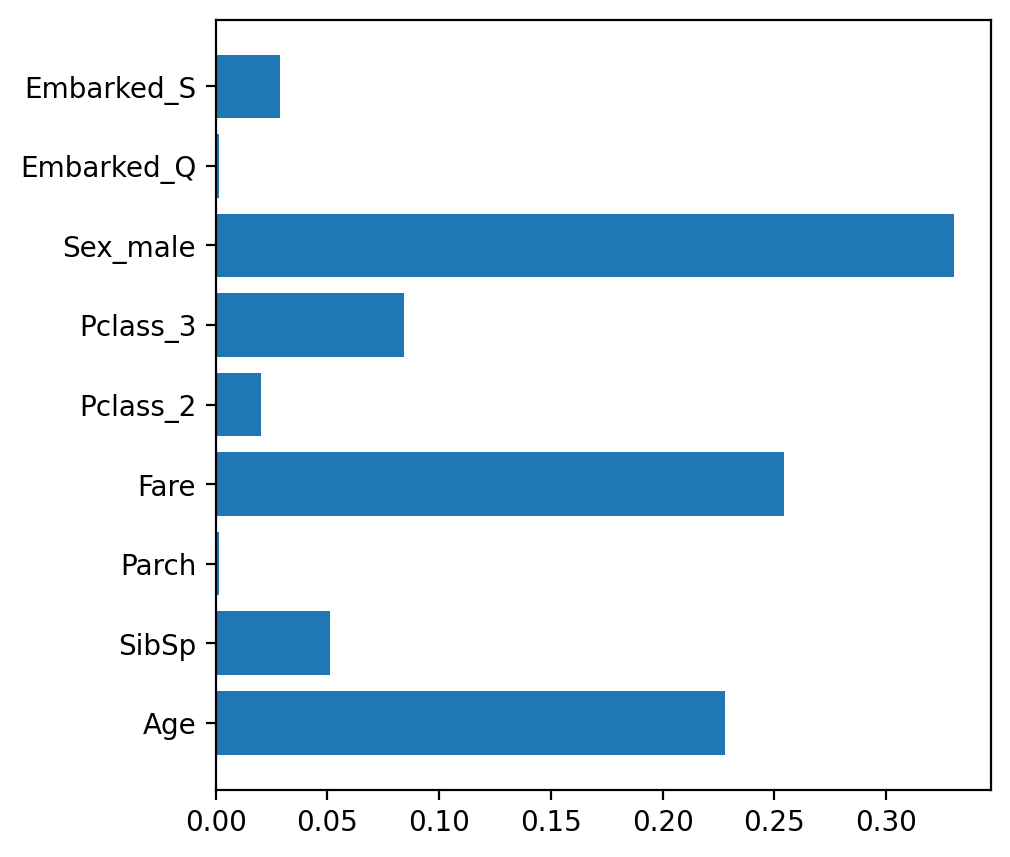

In [55]:
# 변수 중요도
plt.figure(figsize=(5, 5))
plt.barh(list(x), model.feature_importances_)
plt.show()

- 필요하면 다음과 같이 중요도를 기준으로 정럴해 시각화합니다.

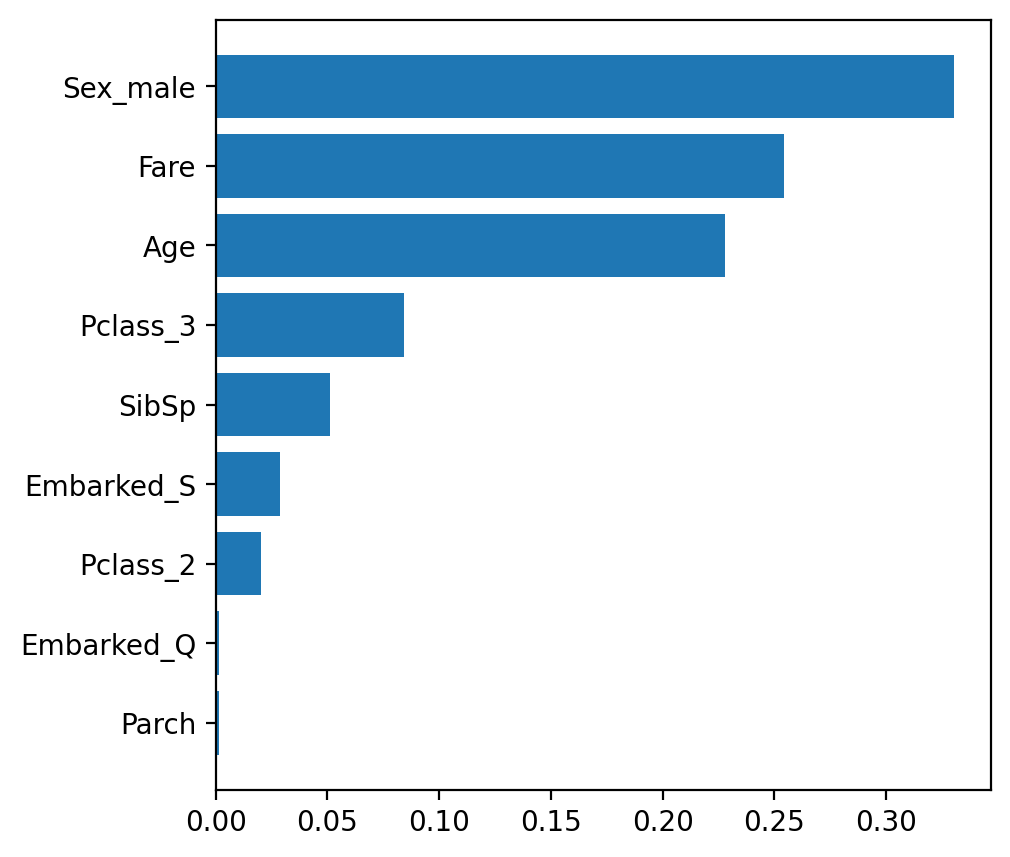

In [56]:
# 데이터프레임 만들기
perf_dic = {'feature':list(x), 'importance': model.feature_importances_}
df = pd.DataFrame(perf_dic)
df.sort_values(by='importance', ascending=True, inplace=True)

# 시각화
plt.figure(figsize=(5, 5))
plt.barh(df['feature'], df['importance'])
plt.show()